# Trace Clustering


In [1]:
import segmentation as sg
import pm4py as pm
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from pm4py.objects.log.util import dataframe_utils
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
path = os.path.join(os.getcwd(),'data', 'mimicel.csv')
df = pd.read_csv(path)

'''
xes = pm.read_xes(path)
df = pm.convert_to_dataframe(xes)
'''

'\nxes = pm.read_xes(path)\ndf = pm.convert_to_dataframe(xes)\n'

## Understanding Data

In [3]:
df.info(verbose=True)
# subject_id as CaseId (consistency wit sepsis benchmark)
# timestamps and activities
# gender or race? (Instead of Age)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7568824 entries, 0 to 7568823
Data columns (total 31 columns):
 #   Column             Dtype  
---  ------             -----  
 0   stay_id            int64  
 1   subject_id         int64  
 2   hadm_id            float64
 3   timestamps         object 
 4   activity           object 
 5   gender             object 
 6   race               object 
 7   arrival_transport  object 
 8   disposition        object 
 9   seq_num            float64
 10  icd_code           object 
 11  icd_version        float64
 12  icd_title          object 
 13  temperature        float64
 14  heartrate          float64
 15  resprate           float64
 16  o2sat              float64
 17  sbp                float64
 18  dbp                float64
 19  pain               object 
 20  acuity             float64
 21  chiefcomplaint     object 
 22  rhythm             object 
 23  name               object 
 24  gsn                float64
 25  ndc               

In [4]:
df = df.rename(columns={
    'subject_id': 'case:concept:name',      
    'activity': 'concept:name',               
    'timestamps': 'time:timestamp'           
})

In [5]:
df.isnull().sum()

stay_id                    0
case:concept:name          0
hadm_id              3015236
time:timestamp             0
concept:name               0
gender               7143796
race                 7143796
arrival_transport    7143796
disposition          6668747
seq_num              6669845
icd_code             6669845
icd_version          6669845
icd_title            6669845
temperature          6259715
heartrate            5801023
resprate             5822404
o2sat                5864053
sbp                  5812828
dbp                  5813628
pain                 6131688
acuity               7150772
chiefcomplaint       7143817
rhythm               7515079
name                 3173867
gsn                  3206271
ndc                  4615706
etc_rn               4615706
etccode              4627281
etcdescription       4627281
med_rn               6126985
gsn_rn               6126985
dtype: int64

In [6]:
df.head()

,stay_id,case:concept:name,hadm_id,time:timestamp,concept:name,gender,race,arrival_transport,disposition,seq_num,...,chiefcomplaint,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn
0,30000012,11714491,21562392.0,2126-02-14 20:22:00,Vital sign check,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,11714491,21562392.0,2126-02-14 20:22:00,Enter the ED,F,WHITE,AMBULANCE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30000012,11714491,21562392.0,2126-02-14 20:22:01,Triage in the ED,NaN,NaN,NaN,NaN,NaN,...,CHANGE IN MENTAL STATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,rifaximin,66295.0,5.486862e+10,1.0,5844.0,Rifamycins and Related Derivative Antibiotics,NaN,NaN
4,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"multivitamin,tx-minerals",2510.0,1.026707e+10,1.0,704.0,Multivitamin and Mineral Combinations,NaN,NaN


In [7]:
non_null_cols = df.columns[~df.isna().any()]
print("모든 행에 NaN이 없는 열들:", list(non_null_cols))

모든 행에 NaN이 없는 열들: ['stay_id', 'case:concept:name', 'time:timestamp', 'concept:name']


## Preprocessing the Data

In [8]:
activities = df['concept:name'].unique() # extract activities

# mapping activities
mapping = {act: chr(97 + i) for i, act in enumerate(activities)} 
df['activity_mapped'] = df['concept:name'].map(mapping)

trace_ordered_df = df.sort_values(by=['case:concept:name', 'time:timestamp']) # order by case ids
trace_mapped_df = trace_ordered_df.groupby('case:concept:name')["activity_mapped"].apply(list).reset_index() # group by case ids

In [9]:
trace_mapped_df.head()

,case:concept:name,activity_mapped
0,10000032,"[b, c, d, d, d, d, d, d, d, d, d, d, a, f, f, ..."
1,10000084,"[b, c, a, d, d, d, d, d, d, a, e, a, f, f, b, ..."
2,10000108,"[b, c, a, f, b, c, a, e, e, f, b, c, d, a, e, ..."
3,10000115,"[b, c, a, a, f, f, f, b, a, c, f, f]"
4,10000117,"[b, c, a, d, a, f, b, c, a, f, f, f, b, c, a, ..."


## Feature Generation and Transformation

In [10]:
trace_mapped_df['activity_str'] = trace_mapped_df['activity_mapped'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer(
    ngram_range=(1, 3),
    stop_words=None,                     
    token_pattern=r'(?u)\b\w+\b'         
)

X = vectorizer.fit_transform(trace_mapped_df['activity_str'])

In [11]:
# Just to check the ngrams
feature_names = vectorizer.get_feature_names_out()
X_df = pd.DataFrame(X.toarray(), columns=feature_names)

X_df.head()

,a,a a,a a a,a a b,a a d,a a e,a a f,a b,a b a,a b c,...,f e a,f e b,f e e,f f,f f a,f f b,f f c,f f d,f f e,f f f
0,23,12,6,0,1,3,2,0,0,0,...,0,0,0,11,0,4,0,0,0,6
1,11,5,4,0,0,0,1,0,0,0,...,0,0,0,2,0,1,0,0,0,0
2,7,2,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,1,0,0,0,...,0,0,0,3,0,1,0,0,0,1
4,6,2,1,0,0,0,1,0,0,0,...,0,0,0,3,0,1,0,0,0,1


## Feature Selection

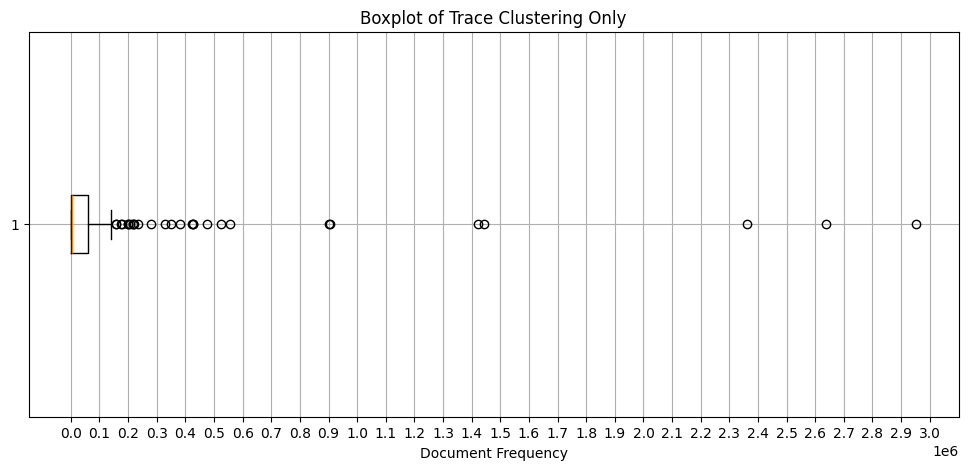

In [12]:
df_counts = np.asarray(X.sum(axis=0)).flatten()

plt.figure(figsize=(12, 5))
plt.boxplot(df_counts, vert=False)
plt.title("Boxplot of Trace Clustering Only")
plt.xlabel("Document Frequency")
plt.grid(True)

max_val = df_counts.max()
tick_interval = 100_000
xticks = np.arange(0, max_val + tick_interval, tick_interval)
plt.xticks(xticks)

plt.show()

In [13]:
# number of ngrams remaining after reducing

# Based on IQR
Q1 = np.percentile(df_counts, 25)
Q3 = np.percentile(df_counts, 75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

idx_iqr = np.where((df_counts >= lower) & (df_counts <= upper))[0]
X_IQR = X[:, idx_iqr]

# Based on Boxplot
idx_500 = np.where(df_counts <= 0.9e6)[0]
X_box = X[:, idx_500]

print(f"Original number of ngrams: {X.shape[1]}")
print(f"Based on IQR: {X_IQR.shape[1]}")
print(f"Based on Box plot: {X_box.shape[1]}")

Original number of ngrams: 189
Based on IQR: 161
Based on Box plot: 182


In [14]:
#Frequency Feature Selection (IQR)

# 1. frequency of ngrams
df_counts = np.asarray(X.sum(axis=0)).flatten()

# 2. IQR 
Q1 = np.percentile(df_counts, 25)
Q3 = np.percentile(df_counts, 75)
IQR = Q3 - Q1

# 3. Lower, Upper IQR
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Reduce ngrams
valid_idx = np.where((df_counts >= lower) & (df_counts <= upper))[0]

# 5. Filter
X_filtered_iqr = X[:, valid_idx]
X_svd = X_filtered_iqr
#Traces in Cluster 0: 872
#Traces in Cluster 1: 178

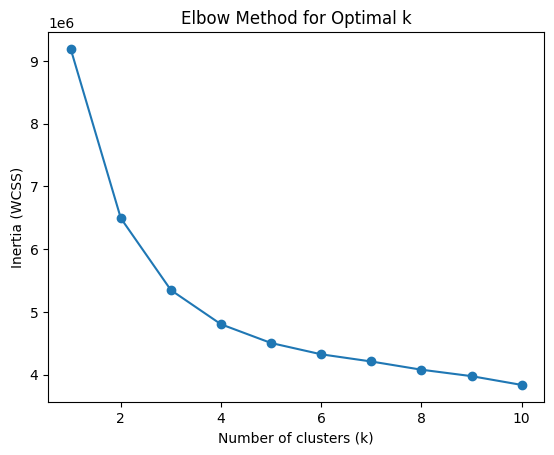

In [15]:
inertia_list = []

for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_svd)  
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertia_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

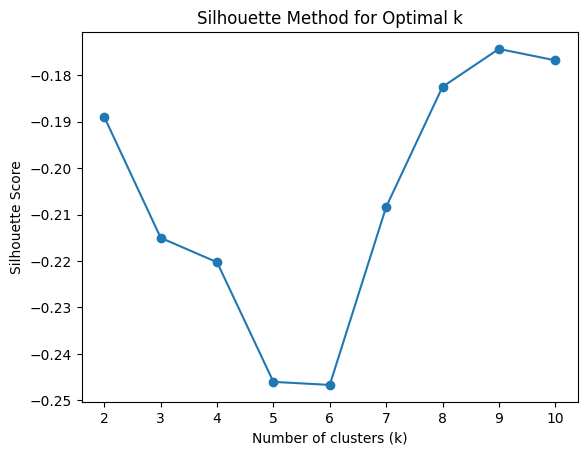

In [16]:
from sklearn.utils import resample

score = []
sample_size = 10000

for i in range(2, 11) :
    km = KMeans(n_clusters = i, random_state = 10)
    km.fit(X_svd)
    pred = km.predict(X_svd)

    if X_svd.shape[0] > sample_size:
        X_sample, labels_sample = resample(X_svd, pred, n_samples=sample_size, random_state=42)
    else:
        X_sample, labels_sample = X_svd, pred  # 샘플 수가 작으면 전체 사용

    sil_score = silhouette_score(X_sample, labels_sample, metric='cosine')
    score.append(sil_score)
    
    #score.append(silhouette_score(X_svd, pred))
    

plt.plot(range(2, 11), score, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()


In [17]:
'''
ngram_ranges = []
for i in range(1, 6):
    for j in range(i, 6):
        ngram_ranges.append((i, j))
trace_texts = trace_mapped_df['activity_str']

fig, axs = plt.subplots(len(ngram_ranges), 2, figsize=(12, 5 * len(ngram_ranges)))
fig.tight_layout(pad=5.0)

for idx, ngram in enumerate(ngram_ranges):
    print(f"\n=== Analyzing ngram_range={ngram} ===")
    
    # Step 1: Vectorization
    vectorizer = CountVectorizer(ngram_range=ngram, token_pattern=r'(?u)\b\w+\b')
    X = vectorizer.fit_transform(trace_texts)

    # Optional: Feature reduction by IQR
    df_counts = np.asarray(X.sum(axis=0)).flatten()
    Q1, Q3 = np.percentile(df_counts, 25), np.percentile(df_counts, 75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    idx_iqr = np.where((df_counts >= lower) & (df_counts <= upper))[0]
    X_filtered = X[:, idx_iqr]
    
    if X_filtered.shape[1] < 2:
        print(f"  Skipping: too few features after filtering: {X_filtered.shape[1]}")
        continue
    
    # Step 2: Elbow Method
    inertia = []
    for k in range(1, 11):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_filtered)
        inertia.append(km.inertia_)
    
    axs[idx, 0].plot(range(1, 11), inertia, marker='o')
    axs[idx, 0].set_title(f'Elbow - ngram_range={ngram}')
    axs[idx, 0].set_xlabel('Number of Clusters (k)')
    axs[idx, 0].set_ylabel('Inertia (WCSS)')
    axs[idx, 0].grid(True)

    # Step 3: Silhouette Score
    score = []
    k_range = []
    for i in range(2, 11) :
        km = KMeans(n_clusters = i, random_state = 10)
        km.fit(X_svd)
        pred = km.predict(X_svd)
    
        if X_svd.shape[0] > sample_size:
            X_sample, labels_sample = resample(X_svd, pred, n_samples=sample_size, random_state=42)
        else:
            X_sample, labels_sample = X_svd, pred  # 샘플 수가 작으면 전체 사용
    
        sil_score = silhouette_score(X_sample, labels_sample, metric='cosine')
        score.append(sil_score)
        k_range.append(i)
        
        #score.append(silhouette_score(X_svd, pred))
    

    axs[idx, 1].plot(k_range, score, marker='o')
    axs[idx, 1].set_title(f'Silhouette - ngram_range={ngram}')
    axs[idx, 1].set_xlabel('Number of Clusters (k)')
    axs[idx, 1].set_ylabel('Silhouette Score')
    axs[idx, 1].grid(True)

plt.tight_layout()
plt.show()
'''

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\melkp\AppData\Local\Temp\ipykernel_7716\1099506289.py:1: SyntaxWarning: invalid escape sequence '\w'
  '''


'\nngram_ranges = []\nfor i in range(1, 6):\n    for j in range(i, 6):\n        ngram_ranges.append((i, j))\ntrace_texts = trace_mapped_df[\'activity_str\']\n\nfig, axs = plt.subplots(len(ngram_ranges), 2, figsize=(12, 5 * len(ngram_ranges)))\nfig.tight_layout(pad=5.0)\n\nfor idx, ngram in enumerate(ngram_ranges):\n    print(f"\n=== Analyzing ngram_range={ngram} ===")\n\n    # Step 1: Vectorization\n    vectorizer = CountVectorizer(ngram_range=ngram, token_pattern=r\'(?u)\x08\\w+\x08\')\n    X = vectorizer.fit_transform(trace_texts)\n\n    # Optional: Feature reduction by IQR\n    df_counts = np.asarray(X.sum(axis=0)).flatten()\n    Q1, Q3 = np.percentile(df_counts, 25), np.percentile(df_counts, 75)\n    IQR = Q3 - Q1\n    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR\n    idx_iqr = np.where((df_counts >= lower) & (df_counts <= upper))[0]\n    X_filtered = X[:, idx_iqr]\n\n    if X_filtered.shape[1] < 2:\n        print(f"  Skipping: too few features after filtering: {X_filtered.shape[1

## Model Training

In [18]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_svd)

trace_mapped_df['cluster'] = kmeans.labels_

In [19]:
trace_mapped_df.head()

,case:concept:name,activity_mapped,activity_str,cluster
0,10000032,"[b, c, d, d, d, d, d, d, d, d, d, d, a, f, f, ...",b c d d d d d d d d d d a f f f f b c e e e a ...,0
1,10000084,"[b, c, a, d, d, d, d, d, d, a, e, a, f, f, b, ...",b c a d d d d d d a e a f f b c a d d d d d d ...,0
2,10000108,"[b, c, a, f, b, c, a, e, e, f, b, c, d, a, e, ...",b c a f b c a e e f b c d a e e a a e a a f,0
3,10000115,"[b, c, a, a, f, f, f, b, a, c, f, f]",b c a a f f f b a c f f,0
4,10000117,"[b, c, a, d, a, f, b, c, a, f, f, f, b, c, a, ...",b c a d a f b c a f f f b c a a a f f,0


In [20]:
cluster_counts = trace_mapped_df['cluster'].value_counts().sort_index()

for cluster_id, count in cluster_counts.items():
    print(f"Traces in Cluster {cluster_id}: {count}")

# n = 2
'''
Traces in Cluster 0: 201271
Traces in Cluster 1: 4195
'''

# n = 9
'''
Traces in Cluster 0: 115393
Traces in Cluster 1: 699
Traces in Cluster 2: 4909
Traces in Cluster 3: 24071
Traces in Cluster 4: 2249
Traces in Cluster 5: 50149
Traces in Cluster 6: 33
Traces in Cluster 7: 174
Traces in Cluster 8: 7789
'''

Traces in Cluster 0: 201271
Traces in Cluster 1: 4195


'\nTraces in Cluster 0: 115393\nTraces in Cluster 1: 699\nTraces in Cluster 2: 4909\nTraces in Cluster 3: 24071\nTraces in Cluster 4: 2249\nTraces in Cluster 5: 50149\nTraces in Cluster 6: 33\nTraces in Cluster 7: 174\nTraces in Cluster 8: 7789\n'

## Process Discovery

C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pandas_utils.dataframe_column_string_to_datetime(
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = strpfromiso.fix_dataframe_column(df[col])
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataf

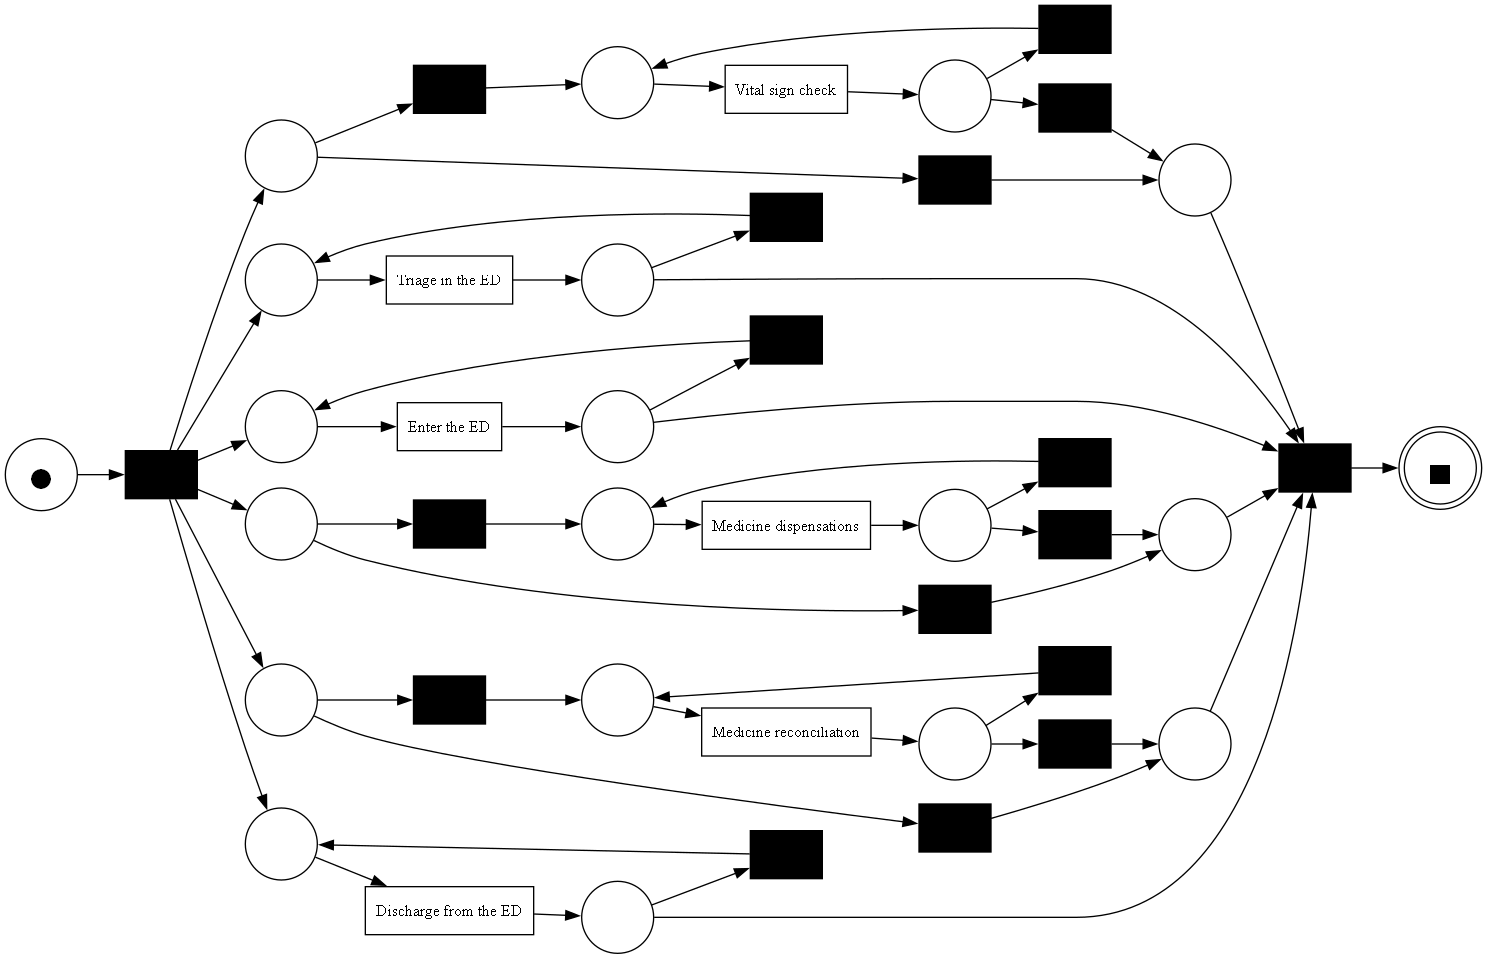

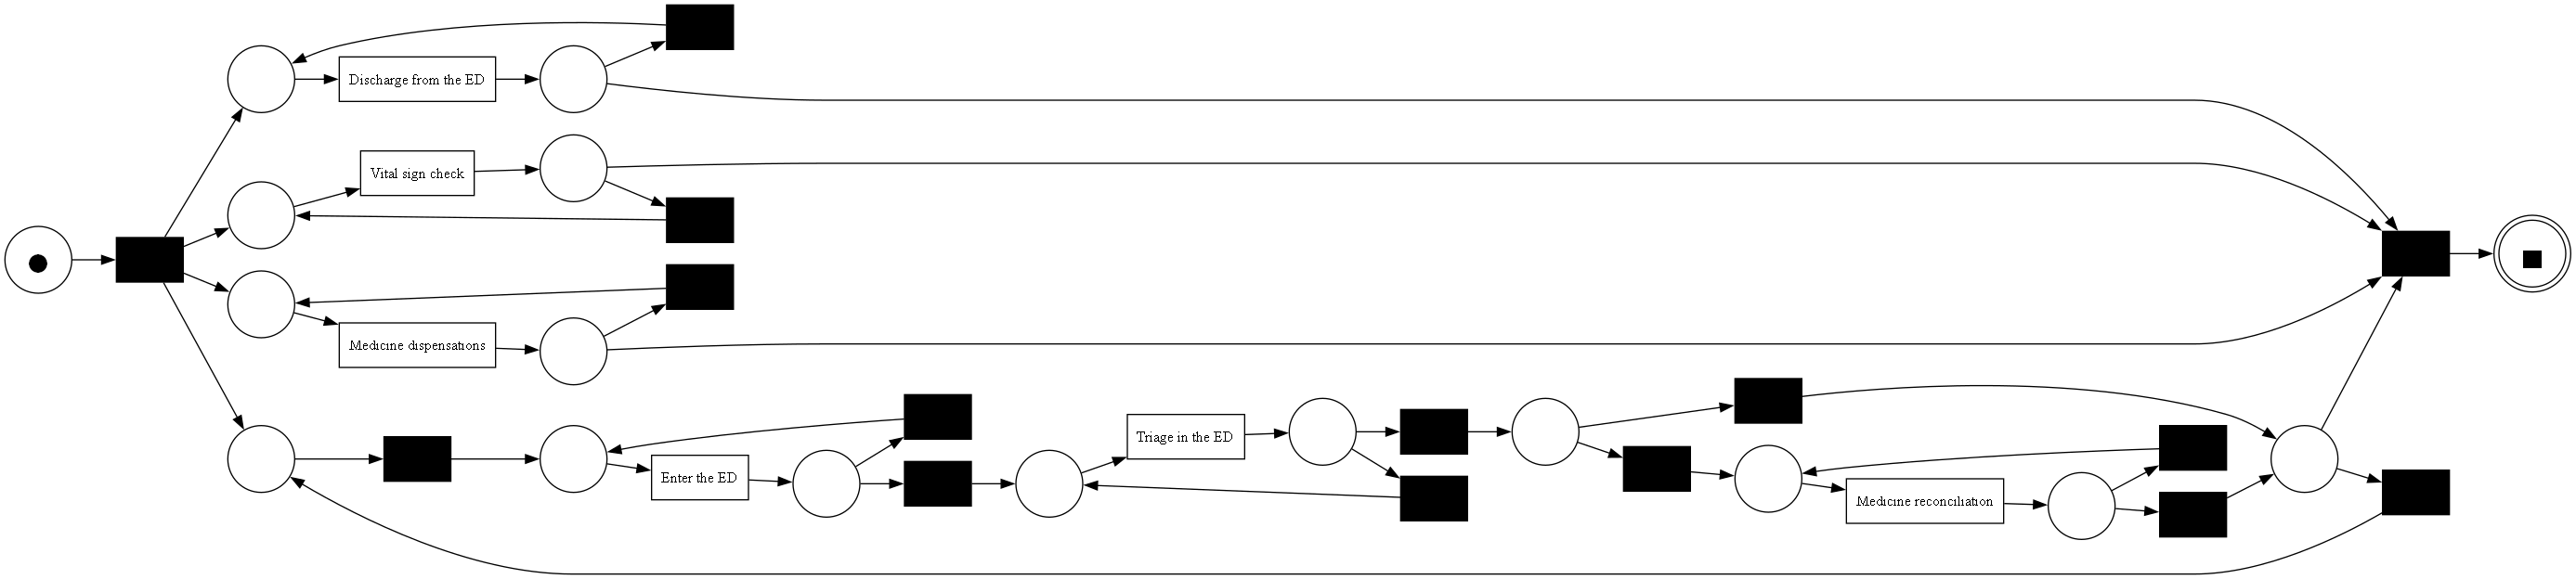

In [21]:
cluster_logs = sg.split_event_log_by_cluster(trace_mapped_df, trace_ordered_df, case_id='case:concept:name')
cluster_models = sg.discover_process_models(cluster_logs)

In [22]:
results_df_tc = sg.evaluate_models_cluster(
    models_dict=cluster_models,
    trace_df=trace_mapped_df,
    full_event_df=trace_ordered_df,
    case_col='case:concept:name',
    time_col='time:timestamp'
)

In [23]:
results_df_tc

,Cluster,# Nodes,# Arcs,CNC,P/T-CD,Cyclomatic Number (CN),ACD,Density,CFC,# Event Classes,# Variants,# Events
0,0,43,56,1.302326,2.617391,14,2.604651,0.031008,6,6,117314,5655384
1,1,38,48,1.263158,2.554622,11,2.526316,0.034139,4,6,4195,1913440


# Process Cube

In [24]:
import segmentation as sg
import pandas as pd
import numpy as np
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.objects.conversion.process_tree import converter as tree_to_petri
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import pm4py as pm
import os
import copy
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.statistics.traces.generic.log import case_statistics

In [25]:
path = os.path.join(os.getcwd(),'data', 'mimicel.csv')
df = pd.read_csv(path)

In [26]:
df = df.rename(columns={
    'subject_id': 'case:concept:name',      
    'activity': 'concept:name',               
    'timestamps': 'time:timestamp'           
})

In [27]:
df = sg.define_race_hierarchy(df)
df = sg.define_time_hierarchy(df)
df = sg.define_activity_hierarchy(df)

In [28]:
pcs = sg.build_pcs_mimic()

In [29]:
pcv = sg.build_pcv(
    granularity={'time': 'month', 'race': 'race_regional', 'activity': 'activity_group'},
    filters={}
)

In [30]:
pcv = sg.rollup_pcv(pcv,pcs,'race')

In [31]:
pcv = sg.drilldown_pcv(pcv,pcs,'race')

In [32]:
pcv['granularity']

{'time': 'month', 'race': 'race_regional', 'activity': 'activity_group'}

In [33]:
mpcv = sg.materialize_process_cube_view(df, pcs, pcv)
print(f"Total number of cells: {len(mpcv)}")
'''
for cell_key, sublog in mpcv.items():
    clean_key = tuple(int(k) if isinstance(k, np.integer) else k for k in cell_key)
    print(f"Cell {clean_key}: {len(sublog)} events")
'''
total_events = sum(len(sublog) for sublog in mpcv.values())
print(f"Total number of events: {total_events}")

Total number of cells: 720
Total number of events: 7568824


In [34]:
#pd.set_option('display.max_rows', None)

In [35]:
dimensions = pcv['visible_dimensions']
columns = [pcv['granularity'][dim] for dim in dimensions] + ['Event Count']

cell_data = []
#columns = list(pcv['granularity'].values()) + ['Event Count']
for cell_key, sublog in mpcv.items():
    cell_data.append((*cell_key, len(sublog))) 

filtered_mpcv = pd.DataFrame(cell_data, columns=columns)
#filtered_mpcv = filtered_mpcv[~filtered_mpcv[pcv['granularity']['race']].str.contains('UNKNOWN')]

top2_per_month = (
    filtered_mpcv.sort_values([pcv['granularity']['time'], 'Event Count'], ascending=[True, False])
      .groupby(pcv['granularity']['time'])
      .head(2)
)

top2_per_race = (
    filtered_mpcv.sort_values([pcv['granularity']['race'], 'Event Count'], ascending=[True, False])
      .groupby(pcv['granularity']['race'])
      .head(2)
)

top2_per_activity = (
    filtered_mpcv
    .groupby(pcv['granularity']['activity'], group_keys=False)
    .apply(lambda df: df.sort_values('Event Count', ascending=False).head(2))
)

#print(top2_per_month)
#rint(top2_per_activity)
#print(top2_per_race)
'''{'time': 'month', 'race': 'race_regional', 'activity': 'activity_name'}'''
# 하나같이 medicine reconciliation이 가장 많은 events를 가짐
# race 중에서는 european이 가장 많은 events를 가짐
# month간의 차이는 크지 않음. 하반기로 갈수록 조금씩 높아짐
'''{'time': 'month', 'race': 'race_regional', 'activity': 'activity_group'}'''
# Medication이 제일 많고, 그다음 monitoring, 그리고 disposition, ed 순 (disposition과 ed의 차이는 크지 않음)
# 여전히 european과 african이 많은 events를 가지고 있음 (3*African = 1 European)
# month간의 차이는 크지 않음. 하반기로 갈수록 조금씩 높아짐
'''{'time': 'month', 'race': 'race_regional', 'activity': 'activity_category'}'''
# Europeans이 각 activity마다 가장 많은 events를 가지고 있음
# 각 race 별로 다 Clinical activity가 가장 많은 event를 가지고 있음
# 각 month별 1,2는 각각 european과 african임
'''{'time': 'month', 'race': 'race_continental', 'activity': 'activity_category'}'''
# White와 Black이 가장 많은 이벤트를 Clinical Data에서 보임
# 각 activity 별로는 White가 가장 많음
# month간의 차이는 크지 않음. 하반기로 갈수록 조금씩 높아짐
'''{'time': 'month', 'race': 'race_specific', 'activity': 'activity_category'}'''
# 여전히 White, black/african american 이 많음
# activity는 white밖에 없음
# month간의 차이는 크지 않음. 하반기로 갈수록 조금씩 높아짐
'''{'time': 'year', 'race': 'race_regional', 'activity': 'activity_category'}'''
# 연도는 처음엔 줄었다가 지날수록 많아지고 또 어느정도 지나면 처음과 비슷한 정도로 작아짐
# Clinical Data
# It's gonna be either white and black or european and africans

'''
최종 비교 셀
(1, BLACK, CLINICAL) 108028
(10, WHITE, CLINICAL) 310026 
'''

C:\Users\melkp\AppData\Local\Temp\ipykernel_7716\2495579354.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values('Event Count', ascending=False).head(2))


'\n최종 비교 셀\n(1, BLACK, CLINICAL) 108028\n(10, WHITE, CLINICAL) 310026 \n'

### Top 2 cells with the highest number of events from different races

In [36]:
sorted_cells = filtered_mpcv.sort_values('Event Count', ascending=False)


cell_list = []
seen_races = set()


race_col = pcv['granularity']['race']
activity_col = pcv['granularity']['activity']
time_col = pcv['granularity']['time']

for _, row in sorted_cells.iterrows():
    race = row[race_col]
    if race not in seen_races:
        seen_races.add(race)
        cell_list.append((row[time_col], race, row[activity_col]))
    if len(cell_list) == 2:
        break

print(cell_list)

[(10, 'EUROPEAN', 'Medication'), (1, 'AFRICAN', 'Medication')]


### Process Discovery

In [37]:
models = sg.discover_models_for_cells(df, cell_list)

Cell (10, 'EUROPEAN', 'Medication'): Skip, since no log
Cell (1, 'AFRICAN', 'Medication'): Skip, since no log


### Evaluation

In [38]:
results_df_pc = sg.evaluate_models_pc(df, models)

In [39]:
results_df_pc

""


# TC --> PC

C:\Users\melkp\OneDrive\문서\Data-Segmentation-Benchmark-in-Process-Mining\segmentation.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race_specific'] = df.groupby('case:concept:name')['race'].transform(lambda x: x.ffill().bfill()).fillna('UNKNOWN')
C:\Users\melkp\OneDrive\문서\Data-Segmentation-Benchmark-in-Process-Mining\segmentation.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race_regional'] = df['race_specific'].map(race_group_map).fillna('UNKNOWN')
C:\Users\melkp\OneDrive\문서\Data-S

Total number of events: 5655384


C:\Users\melkp\AppData\Local\Temp\ipykernel_7716\1822368147.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values('Event Count', ascending=False).head(2))


Cell (10, 'WHITE', 'Clinical') Number of events: 236029


C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pandas_utils.dataframe_column_string_to_datetime(
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pandas_utils.dataframe_column_string_to_datetime(
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\ut

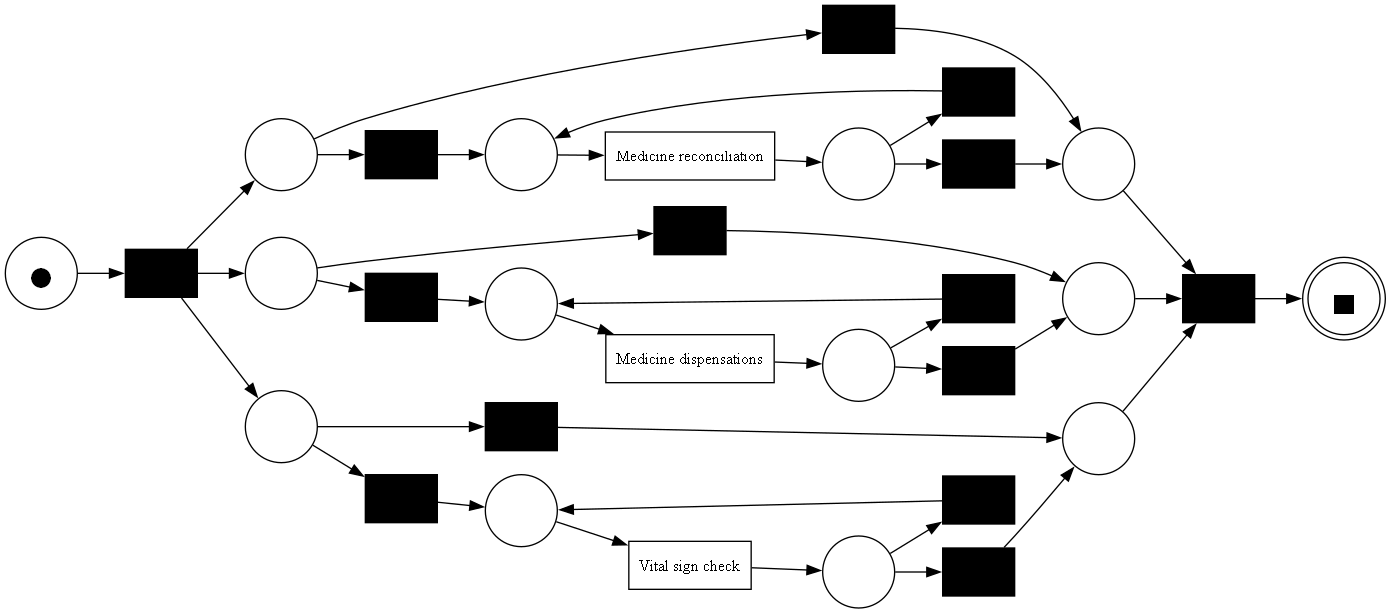

Cell (1, 'BLACK', 'Clinical') Number of events: 64184


C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pandas_utils.dataframe_column_string_to_datetime(
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pandas_utils.dataframe_column_string_to_datetime(
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\ut

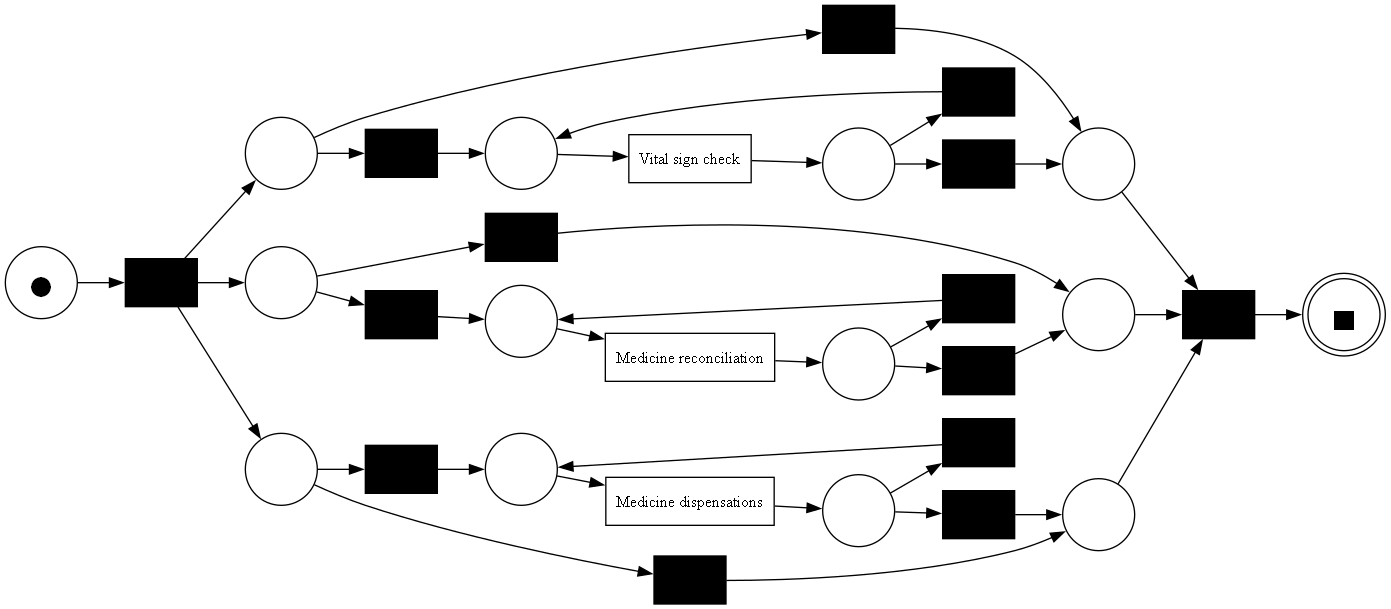

C:\Users\melkp\OneDrive\문서\Data-Segmentation-Benchmark-in-Process-Mining\segmentation.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race_specific'] = df.groupby('case:concept:name')['race'].transform(lambda x: x.ffill().bfill()).fillna('UNKNOWN')
C:\Users\melkp\OneDrive\문서\Data-Segmentation-Benchmark-in-Process-Mining\segmentation.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race_regional'] = df['race_specific'].map(race_group_map).fillna('UNKNOWN')
C:\Users\melkp\OneDrive\문서\Data-S

Total number of events: 1913440
Cell (9, 'WHITE', 'Clinical') Number of events: 74492


C:\Users\melkp\AppData\Local\Temp\ipykernel_7716\1822368147.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values('Event Count', ascending=False).head(2))
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pandas_utils.dataframe_column_string_to_datetime(
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm

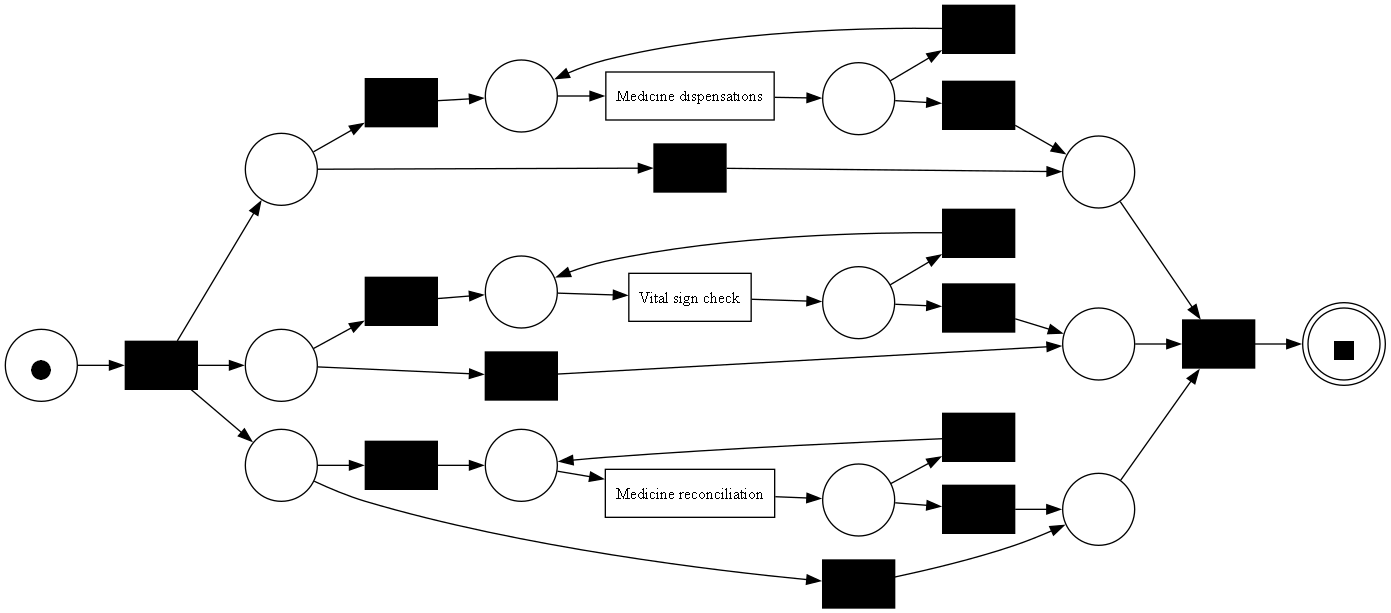

Cell (1, 'BLACK', 'Clinical') Number of events: 43846


C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pandas_utils.dataframe_column_string_to_datetime(
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\util\dataframe_utils.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pandas_utils.dataframe_column_string_to_datetime(
C:\Users\melkp\AppData\Roaming\Python\Python312\site-packages\pm4py\objects\log\ut

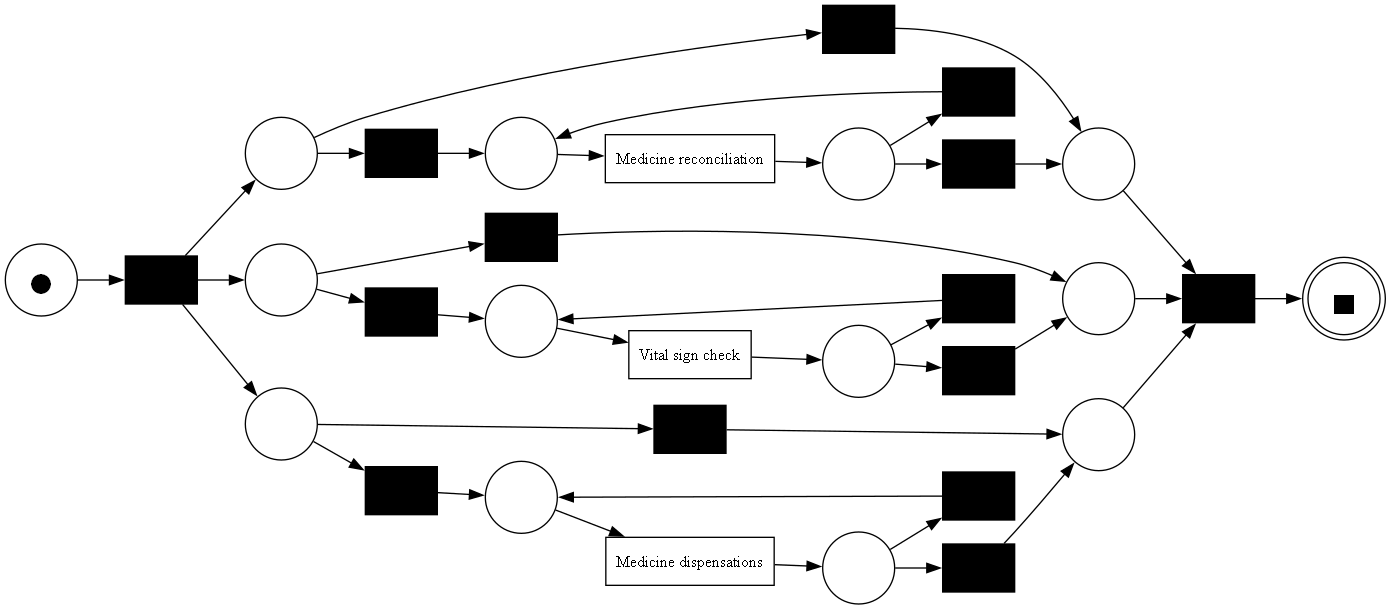

,Cell,# Nodes,# Arcs,CNC,P/T-CD,Cyclomatic Number (CN),ACD,Density,CFC,# Event Classes,# Variants,# Events,cluster_id
0,"(10, WHITE, Clinical)",31,38,1.225806,2.47479,8,2.451613,0.04086,3,3,8727,236029,0
1,"(1, BLACK, Clinical)",31,38,1.225806,2.47479,8,2.451613,0.04086,3,3,2807,64184,0
2,"(9, WHITE, Clinical)",31,38,1.225806,2.47479,8,2.451613,0.04086,3,3,1507,74492,1
3,"(1, BLACK, Clinical)",31,38,1.225806,2.47479,8,2.451613,0.04086,3,3,926,43846,1


In [42]:
all_results = []

for cluster_id, cluster_df in cluster_logs.items():
    cluster_df = sg.define_race_hierarchy(cluster_df)
    cluster_df = sg.define_time_hierarchy(cluster_df)
    cluster_df = sg.define_activity_hierarchy(cluster_df)

    pcs = sg.build_pcs_mimic()
    pcv = sg.build_pcv(
        granularity={'time': 'month', 'race': 'race_regional', 'activity': 'activity_group'},
        filters={}
    )
    pcv = sg.rollup_pcv(pcv,pcs,'race')
    pcv = sg.rollup_pcv(pcv,pcs,'activity')
    
    mpcv = sg.materialize_process_cube_view(cluster_df, pcs, pcv)
    '''
    print(f"Total number of Cells: {len(mpcv)}")
    for cell_key, sublog in mpcv.items():
        print(f"Cell {cell_key}: {len(sublog)} events")
    '''
    total_events = sum(len(sublog) for sublog in mpcv.values())
    print(f"Total number of events: {total_events}")

    dimensions = pcv['visible_dimensions']
    columns = [pcv['granularity'][dim] for dim in dimensions] + ['Event Count']
    
    cell_data = []
    for cell_key, sublog in mpcv.items():
        cell_data.append((*cell_key, len(sublog))) 
    
    filtered_mpcv = pd.DataFrame(cell_data, columns=columns)
    
    top2_per_month = (
        filtered_mpcv.sort_values([pcv['granularity']['time'], 'Event Count'], ascending=[True, False])
          .groupby(pcv['granularity']['time'])
          .head(2)
    )
    
    top2_per_race = (
        filtered_mpcv.sort_values([pcv['granularity']['race'], 'Event Count'], ascending=[True, False])
          .groupby(pcv['granularity']['race'])
          .head(2)
    )
    
    top2_per_activity = (
        filtered_mpcv
        .groupby(pcv['granularity']['activity'], group_keys=False)
        .apply(lambda df: df.sort_values('Event Count', ascending=False).head(2))
    )
    
    sorted_cells = filtered_mpcv.sort_values('Event Count', ascending=False)

    cell_list = []
    seen_races = set()
    
    
    race_col = pcv['granularity']['race']
    activity_col = pcv['granularity']['activity']
    time_col = pcv['granularity']['time']
    
    for _, row in sorted_cells.iterrows():
        race = row[race_col]
        if race not in seen_races:
            seen_races.add(race)
            cell_list.append((row[time_col], race, row[activity_col]))
        if len(cell_list) == 2:
            break
    
    models_tc_pc = sg.discover_models_for_cells(cluster_df, cell_list)
    
    results_df_tc_pc = sg.evaluate_models_pc(cluster_df, models_tc_pc)
    results_df_tc_pc['cluster_id'] = cluster_id
    all_results.append(results_df_tc_pc)
    
results_df_tc_pc_all = pd.concat(all_results, ignore_index=True)

results_df_tc_pc_all